In [1]:
import tensorflow as tf
import time
import numpy as np
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Softmax,Flatten,MaxPooling2D,Dropout,Activation, Lambda, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import kullback_leibler_divergence as KLD_Loss, categorical_crossentropy as logloss
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# 파라미터 수에 따른 메모리 크기 계산 (float32 타입 기준, 1 파라미터 = 4 바이트)
def params_to_memory(params):
    memory_bytes = params * 4
    memory_kb = memory_bytes / 1024
    memory_mb = memory_kb / 1024
    return memory_bytes, memory_kb, memory_mb

def KD_loss(y_true,y_pred,lambd=0.5,T=10.0):
  y_true,y_true_KD = y_true[:,:NUM_CLASSES],y_true[:,NUM_CLASSES:]
  y_pred,y_pred_KD = y_pred[:,:NUM_CLASSES],y_pred[:,NUM_CLASSES:]
  # Classic cross-entropy (without temperature)
  CE_loss = logloss(y_true,y_pred)
  # KL-Divergence loss for softened output (with temperature)
  KL_loss = T**2*KLD_Loss(y_true_KD,y_pred_KD)

  return lambd*CE_loss + (1-lambd)*KL_loss

def accuracy(y_true,y_pred):
  return categorical_accuracy(y_true,y_pred)

def measure_inference_time(model, x_test, n_runs=100):
    start_time = time.time()
    for _ in range(n_runs):
        _ = model.predict(x_test)
    end_time = time.time()
    avg_time_per_run = (end_time - start_time) / n_runs
    return avg_time_per_run

NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Normalize the dataset
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape each example to WIDTH*HEIGHT*CHANNELS for Convolution operation
# x_test = x_test.reshape(-1,,28,1)
# x_train = x_train.reshape(-1,28,28,1)

print("=======================")


Teacher = Sequential() # Must define the input shape in the first layer of the neural network
Teacher.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(32,32,3)))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
Teacher.add(MaxPooling2D(pool_size=2))
Teacher.add(Flatten())
Teacher.add(Dense(256, activation='relu'))
Teacher.add(Dropout(0.5))
Teacher.add(Dense(10))
Teacher.add(Activation('softmax'))

Teacher.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# Teacher.summary()

Student = Sequential() #a Must define the input shape in the first layer of the neural network
Student.add(Flatten(input_shape=(32,32,3)))
Student.add(Dense(64, activation='relu'))
Student.add(Dense(10))
# Student.summary()


AloneModel = Sequential() #a Must define the input shape in the first layer of the neural netAloneStudent = Sequential() #a Must define the input shape in the first layer of the neural network
AloneModel.add(Flatten(input_shape=(32,32,3)))
AloneModel.add(Dense(64, activation='relu'))
AloneModel.add(Dense(10,activation="softmax"))
# AloneModel.summary()

teacher_total_params = Teacher.count_params()
students_total_params = Student.count_params()
alone_total_params = AloneModel.count_params()

teacher_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Teacher.trainable_weights])
students_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Student.trainable_weights])
alone_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in AloneModel.trainable_weights])

teacher_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Teacher.non_trainable_weights])
students_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in Student.non_trainable_weights])
alone_non_trainable_params = np.sum([np.prod(v.get_shape().as_list()) for v in AloneModel.non_trainable_weights])

teacher_total_memory_bytes, teacher_total_memory_kb, teacher_total_memory_mb = params_to_memory(teacher_total_params)
teacher_trainable_memory_bytes, teacher_trainable_memory_kb, teacher_trainable_memory_mb = params_to_memory(teacher_trainable_params)
teacher_non_trainable_memory_bytes, teacher_non_trainable_memory_kb, teacher_non_trainable_memory_mb = params_to_memory(teacher_non_trainable_params)

students_total_memory_bytes, students_total_memory_kb, students_total_memory_mb = params_to_memory(students_total_params)
students_trainable_memory_bytes, students_trainable_memory_kb, students_trainable_memory_mb = params_to_memory(students_trainable_params)
students_non_trainable_memory_bytes, students_non_trainable_memory_kb, students_non_trainable_memory_mb = params_to_memory(students_non_trainable_params)

alone_total_memory_bytes, alone_total_memory_kb, alone_total_memory_mb = params_to_memory(alone_total_params)
alone_trainable_memory_bytes, alone_trainable_memory_kb, alone_trainable_memory_mb = params_to_memory(alone_trainable_params)
alone_non_trainable_memory_bytes, alone_non_trainable_memory_kb, alone_non_trainable_memory_mb = params_to_memory(alone_non_trainable_params)


print("Teacher:")
print(f"Total parameters: {teacher_total_params} ({teacher_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {teacher_trainable_params} ({teacher_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {teacher_non_trainable_params} ({teacher_non_trainable_memory_mb:.2f} MB)")


print("Student:")
print(f"Total parameters: {students_total_params} ({students_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {students_trainable_params} ({students_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {students_non_trainable_params} ({students_non_trainable_memory_mb:.2f} MB)")


print("Alone:")
print(f"Total parameters: {alone_total_params} ({alone_total_memory_mb:.2f} MB)")
print(f"Trainable parameters: {alone_trainable_params} ({alone_trainable_memory_mb:.2f} MB)")
print(f"Non-trainable parameters: {alone_non_trainable_params} ({alone_non_trainable_memory_mb:.2f} MB)")

x_train shape: (50000, 32, 32, 3) y_train shape: (50000, 1)


2024-07-16 17:02:34.613058: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-07-16 17:02:34.613616: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 17:02:34.624085: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Teacher:
Total parameters: 1060074 (4.04 MB)
Trainable parameters: 1060074 (4.04 MB)
Non-trainable parameters: 0.0 (0.00 MB)
Student:
Total parameters: 197322 (0.75 MB)
Trainable parameters: 197322 (0.75 MB)
Non-trainable parameters: 0.0 (0.00 MB)
Alone:
Total parameters: 197322 (0.75 MB)
Trainable parameters: 197322 (0.75 MB)
Non-trainable parameters: 0.0 (0.00 MB)


In [2]:
myCP = ModelCheckpoint(save_best_only=True, filepath='teacher.h5', monitor='val_accuracy')
Teacher.fit(x_train,
         y_train,
         batch_size=128,
         epochs=20,
         validation_split=0.2,
         callbacks=[myCP])

2024-07-16 17:02:36.431332: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-07-16 17:02:36.434137: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2918000000 Hz


Epoch 1/20
313/313 [==============================] - 24s 73ms/step - loss: 1.9081 - accuracy: 0.3028 - val_loss: 1.3440 - val_accuracy: 0.5301
Epoch 2/20
313/313 [==============================] - 25s 79ms/step - loss: 1.3749 - accuracy: 0.5092 - val_loss: 1.2054 - val_accuracy: 0.5822
Epoch 3/20
313/313 [==============================] - 13s 40ms/step - loss: 1.2251 - accuracy: 0.5646 - val_loss: 1.1165 - val_accuracy: 0.6059
Epoch 4/20
313/313 [==============================] - 24s 77ms/step - loss: 1.1361 - accuracy: 0.5973 - val_loss: 1.0327 - val_accuracy: 0.6413
Epoch 5/20
313/313 [==============================] - 25s 80ms/step - loss: 1.0719 - accuracy: 0.6204 - val_loss: 0.9737 - val_accuracy: 0.6597
Epoch 6/20
313/313 [==============================] - 26s 83ms/step - loss: 1.0057 - accuracy: 0.6457 - val_loss: 0.9646 - val_accuracy: 0.6604
Epoch 7/20
313/313 [==============================] - 11s 36ms/step - loss: 0.9659 - accuracy: 0.6568 - val_loss: 0.9277 - val_accuracy:

In [3]:
# Retrieve best model from saved
Teacher = load_model('teacher.h5')

# # Evaluation with test set
# Teacher.evaluate(x_test,y_test)
teacher_loss, teacher_accuracy = Teacher.evaluate(x_test, y_test)
print(f"Teacher Model - Loss: {teacher_loss}, Accuracy: {teacher_accuracy}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8244 - accuracy: 0.7169
Teacher Model - Loss: 0.8243565559387207, Accuracy: 0.7168999910354614


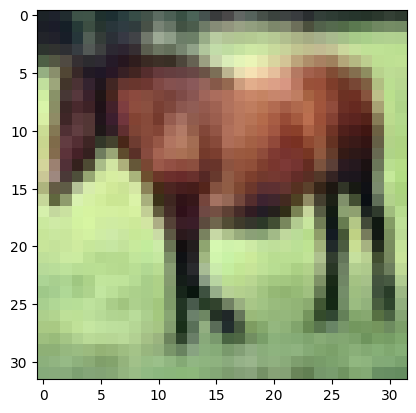

In [4]:
Teacher_logits = Model(Teacher.input, Teacher.layers[-2].output)

logits_plot = []
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

item_idx = 7
item_image = x_train[item_idx]

plt.imshow(item_image)
plt.show()

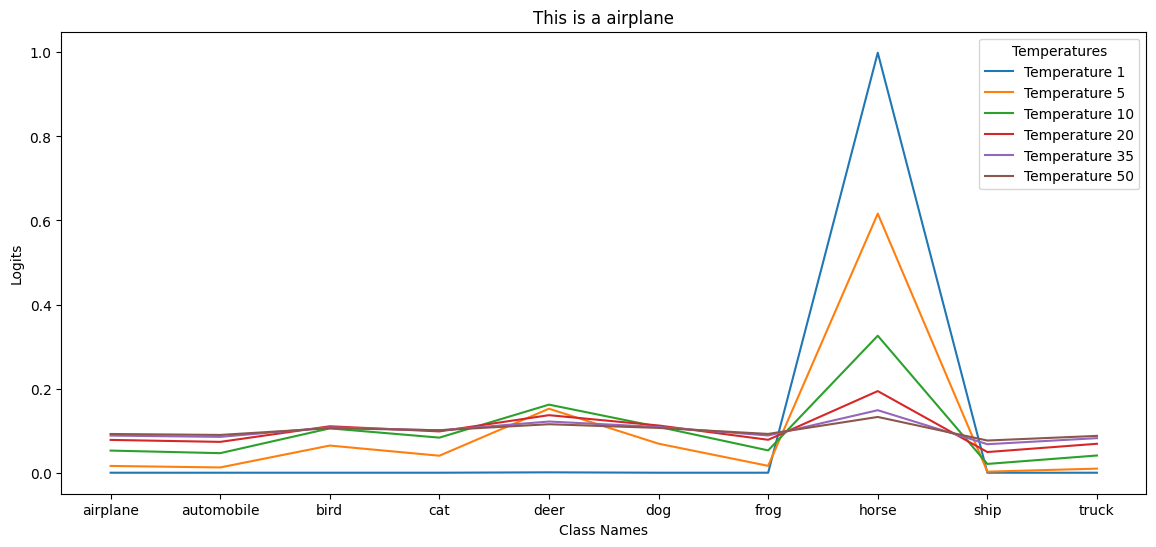

In [5]:
Temperatures = [1, 5, 10, 20, 35, 50]

for Temperature in Temperatures:
    T_layer = Lambda(lambda x: x / Temperature)(Teacher_logits.output)
    Softmax_layer = Softmax()(T_layer)
    Teacher_logits_soften = Model(Teacher.input, Softmax_layer)

    logits_plot.append(Teacher_logits_soften.predict(np.array([item_image])))

plt.figure(figsize=(14, 6))
for i in range(len(Temperatures)):
    sns.lineplot(x=class_names, y=logits_plot[i][0], label=f'Temperature {Temperatures[i]}')

plt.title(f'This is a {class_names[np.argmax(y_train[item_idx])]}')
plt.xlabel('Class Names')
plt.ylabel('Logits')
plt.legend(title="Temperatures")
plt.show()

In [6]:
Temperature = 3.25
T_layer = Lambda(lambda x:x/Temperature)(Teacher_logits.output)
Softmax_layer = Activation('softmax')(T_layer)
Teacher_soften = Model(Teacher.input,Softmax_layer)

# Predict and convert to sparse categorical matrix
y_train_new = Teacher_soften.predict(x_train)
y_test_new = Teacher_soften.predict(x_test)

y_train_new = np.c_[to_categorical(y_train),y_train_new]
y_test_new = np.c_[to_categorical(y_test),y_test_new]

In [7]:
student_logits = Student.layers[-1].output

# Compute softmax
probs = Activation("softmax")(student_logits)

# Compute softmax with softened logits
logits_T = Lambda(lambda x:x/Temperature)(student_logits)
probs_T = Activation("softmax")(logits_T)

CombinedLayers = concatenate([probs,probs_T])

StudentModel = Model(Student.input,CombinedLayers)

StudentModel.compile(optimizer='adam',loss=lambda y_true,y_pred: KD_loss(y_true, y_pred,lambd=0.5,T=Temperature),metrics=[accuracy])

myCP = ModelCheckpoint(save_best_only=True,filepath='student.h5',monitor = 'val_accuracy')

StudentModel.fit(x_train,y_train_new,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
333/333 [==============================] - 2s 4ms/step - loss: 3.7128 - accuracy: 0.2565 - val_loss: 3.0064 - val_accuracy: 0.3441
Epoch 2/50
333/333 [==============================] - 1s 3ms/step - loss: 3.0180 - accuracy: 0.3639 - val_loss: 2.8894 - val_accuracy: 0.3525
Epoch 3/50
333/333 [==============================] - 1s 4ms/step - loss: 2.9031 - accuracy: 0.3727 - val_loss: 2.8310 - val_accuracy: 0.3701
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 2.8270 - accuracy: 0.3849 - val_loss: 3.0237 - val_accuracy: 0.3547
Epoch 5/50
333/333 [==============================] - 1s 4ms/step - loss: 2.8301 - accuracy: 0.3856 - val_loss: 2.8073 - val_accuracy: 0.3608
E

In [8]:
StudentModel.load_weights('student.h5')
# StudentModel.evaluate(x_train,y_train_new)

student_loss, student_accuracy = StudentModel.evaluate(x_train,y_train_new)
print(f"Student Model (with KD) - Loss: {student_loss}, Accuracy: {student_accuracy}")


1563/1563 [==============================] - 3s 2ms/step - loss: 2.2732 - accuracy: 0.4522
Student Model (with KD) - Loss: 2.273191213607788, Accuracy: 0.45217999815940857


In [9]:
AloneModel.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#val_acc -> val_accuracy
myCP = ModelCheckpoint(_best_only=True,filepath='alone.h5',monitor = 'val_accuracy')

AloneModel.fit(x_train,y_train,epochs=50,validation_split=0.15,batch_size=128,callbacks=[myCP])

Epoch 1/50
333/333 [==============================] - 2s 4ms/step - loss: 2.1560 - accuracy: 0.1982 - val_loss: 2.0156 - val_accuracy: 0.2564
Epoch 2/50
333/333 [==============================] - 1s 2ms/step - loss: 1.9393 - accuracy: 0.2792 - val_loss: 1.9200 - val_accuracy: 0.2825
Epoch 3/50
333/333 [==============================] - 1s 2ms/step - loss: 1.8839 - accuracy: 0.3079 - val_loss: 1.8833 - val_accuracy: 0.3089
Epoch 4/50
333/333 [==============================] - 1s 3ms/step - loss: 1.8607 - accuracy: 0.3233 - val_loss: 1.9046 - val_accuracy: 0.3111
Epoch 5/50
333/333 [==============================] - 1s 3ms/step - loss: 1.8571 - accuracy: 0.3242 - val_loss: 1.8624 - val_accuracy: 0.3243
Epoch 6/50
333/333 [==============================] - 1s 3ms/step - loss: 1.8384 - accuracy: 0.3369 - val_loss: 1.8587 - val_accuracy: 0.3232
Epoch 7/50
333/333 [==============================] - 1s 2ms/step - loss: 1.8298 - accuracy: 0.3399 - val_loss: 1.8546 - val_accuracy: 0.3309
Epoch 

In [10]:
AloneModel = load_model("alone.h5")
# AloneModel.evaluate(x_test,y_test)
alone_loss, alone_accuracy = AloneModel.evaluate(x_test, y_test)
print(f"Alone Model (without KD) - Loss: {alone_loss}, Accuracy: {alone_accuracy}")

313/313 [==============================] - 1s 1ms/step - loss: 1.8451 - accuracy: 0.3336
Alone Model (without KD) - Loss: 1.8451308012008667, Accuracy: 0.3336000144481659


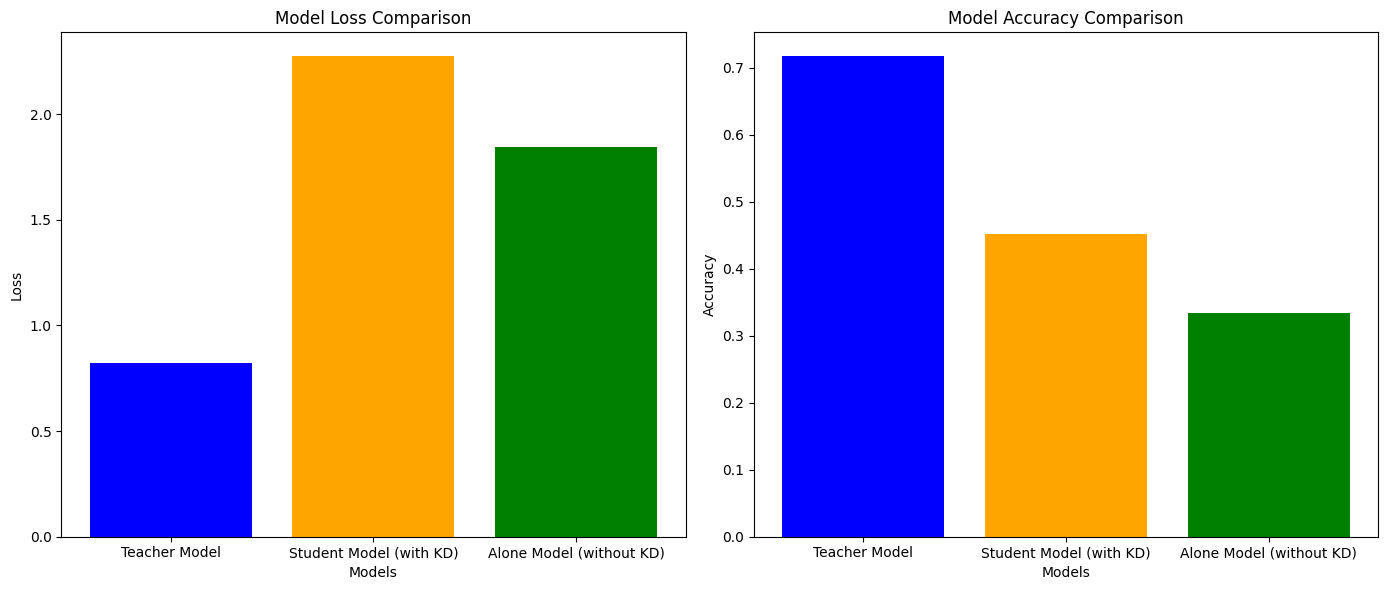

In [11]:
# Data for plotting
models = ['Teacher Model', 'Student Model (with KD)', 'Alone Model (without KD)']
losses = [teacher_loss, student_loss, alone_loss]
accuracies = [teacher_accuracy, student_accuracy, alone_accuracy]

# Plotting the losses
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(models, losses, color=['blue', 'orange', 'green'])
plt.title('Model Loss Comparison')
plt.xlabel('Models')
plt.ylabel('Loss')

# Plotting the accuracies
plt.subplot(1, 2, 2)
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

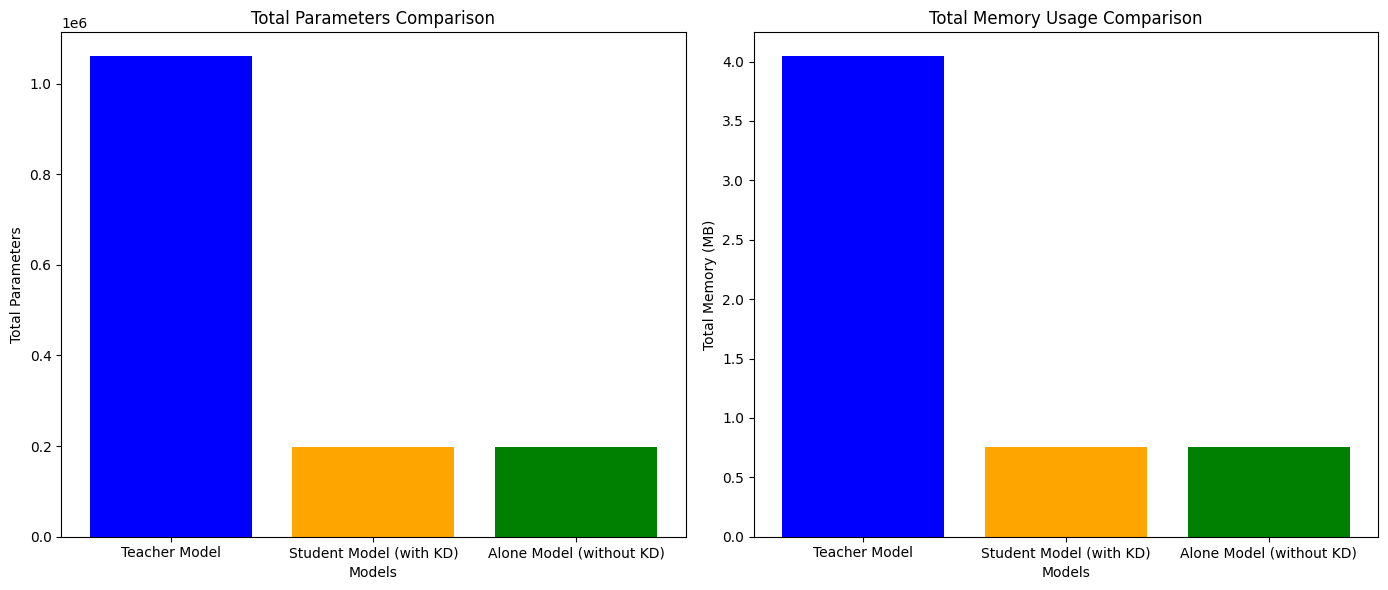

In [13]:
# Compare Parameters and memory usage

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.bar(models, [teacher_total_params, students_total_params, alone_total_params], color=['blue', 'orange', 'green'])
plt.title('Total Parameters Comparison')
plt.xlabel('Models')
plt.ylabel('Total Parameters')

plt.subplot(1, 2, 2)
plt.bar(models, [teacher_total_memory_mb, students_total_memory_mb, alone_total_memory_mb], color=['blue', 'orange', 'green'])
plt.title('Total Memory Usage Comparison')
plt.xlabel('Models')
plt.ylabel('Total Memory (MB)')

plt.tight_layout()
plt.show()

In [12]:
# Measure inference time for Teacher and Student models
teacher_inference_time = measure_inference_time(Teacher, x_test)
student_inference_time = measure_inference_time(StudentModel, x_test)

print(f"Teacher Model - Average Inference Time: {teacher_inference_time:.6f} seconds")
print(f"Student Model - Average Inference Time: {student_inference_time:.6f} seconds")

Teacher Model - Average Inference Time: 1.167864 seconds
Student Model - Average Inference Time: 0.493496 seconds


In [22]:
#calculate memory

# student_accuracy, alone_accuracy
print(f"{student_accuracy=}")
print(f"{alone_accuracy=}")
acc_percentage = (student_accuracy - alone_accuracy) / alone_accuracy * 100
print(acc_percentage)

# temp = student_accuracy * 0.65
# print(temp)

# temp2 = alone_accuracy * 1.35
# print(temp2)

infer_time = (student_inference_time - teacher_inference_time) / teacher_inference_time * 100
print(infer_time)

#teacher model, students model memory comparison
memory_comp = (students_total_memory_mb - teacher_total_memory_mb) / teacher_total_memory_mb * 100
print(memory_comp)

# plt.subplot(1, 2, 2)
# plt.bar(models, [teacher_total_memory_mb, students_total_memory_mb, alone_total_memory_mb], color=['blue', 'orange', 'green'])
# plt.title('Total Memory Usage Comparison')
# plt.xlabel('Models')
# plt.ylabel('Total Memory (MB)')

student_accuracy=0.45217999815940857
alone_accuracy=0.3336000144481659
35.54555712696691
-57.74373012709025
-81.38601644790835
